In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import torchvision.utils as vutils
# from torchsummary import summary

# from pushover import notify
# from utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

%load_ext autoreload
%autoreload 2

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
bs = 32

In [4]:
# Load Data
dataset = datasets.ImageFolder(root='/Users/jagtarsingh/OneDrive/UPenn/CIS680/VAE/cufs', transform=transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(), 
]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)
len(dataset.imgs), len(dataloader)

(183, 6)

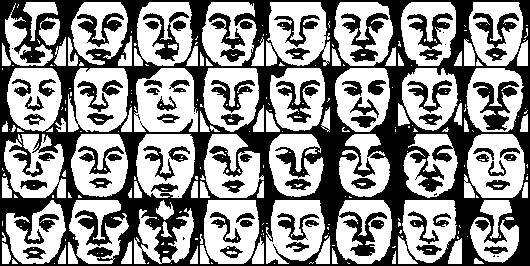

In [5]:
# Fixed input for debugging
fixed_x, _ = next(iter(dataloader))
save_image(fixed_x, 'real_image.png')

Image('real_image.png')

In [6]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [7]:
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [8]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=64):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [9]:
image_channels = fixed_x.size(1)
print(image_channels)

3


In [10]:
model = VAE(image_channels=image_channels).to(device)
# model.load_state_dict(torch.load('vae.torch', map_location='cpu'))

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

In [12]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [60]:
epochs = 50

In [61]:
for epoch in range(epochs):
    for idx, (images, _) in enumerate(dataloader):
        recon_images, mu, logvar = model(images)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                epochs, loss.data[0]/bs, bce.data[0]/bs, kld.data[0]/bs)
        print(to_print)

# # notify to android when finished training
# notify(to_print, priority=1)

torch.save(model.state_dict(), 'vae.torch')

/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # Remove the CWD from sys.path while we load stuff.


Epoch[1/50] Loss: 4183.802 4183.513 0.289
Epoch[1/50] Loss: 3923.384 3923.009 0.375
Epoch[1/50] Loss: 4270.232 4269.849 0.384
Epoch[1/50] Loss: 4251.488 4251.177 0.311
Epoch[1/50] Loss: 4180.905 4180.610 0.295
Epoch[1/50] Loss: 2977.652 2977.317 0.335
Epoch[2/50] Loss: 4145.522 4145.169 0.352
Epoch[2/50] Loss: 3983.625 3983.294 0.331
Epoch[2/50] Loss: 4235.292 4234.988 0.304
Epoch[2/50] Loss: 3994.796 3994.400 0.396
Epoch[2/50] Loss: 4276.352 4276.033 0.319
Epoch[2/50] Loss: 2921.554 2921.258 0.296
Epoch[3/50] Loss: 4085.105 4084.807 0.298
Epoch[3/50] Loss: 3954.787 3954.451 0.336
Epoch[3/50] Loss: 4047.690 4047.266 0.424
Epoch[3/50] Loss: 4033.345 4032.966 0.379
Epoch[3/50] Loss: 4230.724 4230.419 0.305
Epoch[3/50] Loss: 2989.158 2988.866 0.291
Epoch[4/50] Loss: 3931.446 3931.062 0.385
Epoch[4/50] Loss: 4136.079 4135.732 0.347
Epoch[4/50] Loss: 3915.284 3914.903 0.381
Epoch[4/50] Loss: 4048.087 4047.718 0.369
Epoch[4/50] Loss: 4094.069 4093.716 0.353
Epoch[4/50] Loss: 2971.970 2971.69

Epoch[33/50] Loss: 2734.098 2733.203 0.895
Epoch[33/50] Loss: 2732.738 2731.877 0.861
Epoch[33/50] Loss: 2588.406 2587.601 0.805
Epoch[33/50] Loss: 2628.114 2627.245 0.869
Epoch[33/50] Loss: 2572.154 2571.052 1.102
Epoch[33/50] Loss: 1953.261 1952.328 0.933
Epoch[34/50] Loss: 2539.159 2538.223 0.935
Epoch[34/50] Loss: 2587.630 2586.646 0.984
Epoch[34/50] Loss: 2563.813 2562.834 0.979
Epoch[34/50] Loss: 2628.273 2627.405 0.868
Epoch[34/50] Loss: 2573.686 2572.703 0.983
Epoch[34/50] Loss: 1977.665 1976.671 0.994
Epoch[35/50] Loss: 2554.520 2553.560 0.960
Epoch[35/50] Loss: 2477.791 2476.824 0.967
Epoch[35/50] Loss: 2510.144 2509.079 1.064
Epoch[35/50] Loss: 2440.370 2439.316 1.055
Epoch[35/50] Loss: 2456.403 2455.325 1.078
Epoch[35/50] Loss: 1904.555 1903.547 1.008
Epoch[36/50] Loss: 2445.365 2444.359 1.006
Epoch[36/50] Loss: 2383.610 2382.570 1.040
Epoch[36/50] Loss: 2467.031 2465.925 1.106
Epoch[36/50] Loss: 2438.838 2437.621 1.217
Epoch[36/50] Loss: 2583.574 2582.388 1.187
Epoch[36/50

In [25]:
def compare(x):
    recon_x, _, _ = model(x)
    return torch.cat([x, recon_x])

In [57]:
def compare2(x):
    recon_x, _, _ = model(x)
    return recon_x

Generated Images 


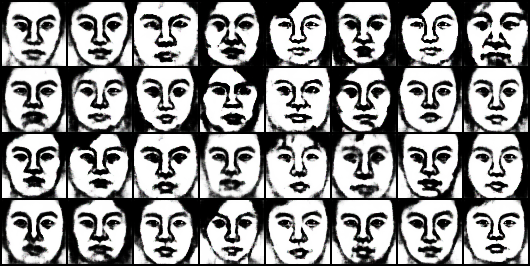

Real Images 


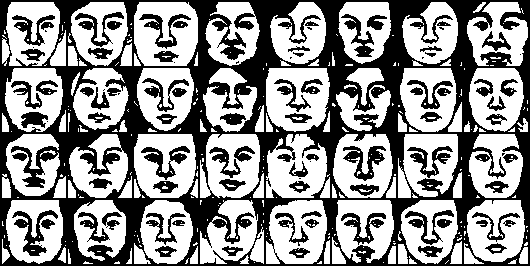

In [68]:
# sample = torch.randn(bs, 1024)
# compare_x = vae.decoder(sample)

# fixed_x, _ = next(iter(dataloader))
# fixed_x = fixed_x[:8]
import pdb
real_img = dataset[randint(1, 150)][0].unsqueeze(0)

compare_x = compare2(real_img)
for i in range(31):
    
    fixed_x = dataset[randint(1, 150)][0].unsqueeze(0)
#     pdb.set_trace()
    real_img = torch.cat([real_img, fixed_x])

    new_compare_x = compare2(fixed_x)
    
    compare_x = torch.cat([compare_x, new_compare_x])
    
    
    

save_image(compare_x.data.cpu(), 'fake_image.png')
save_image(real_img.data.cpu(), 'real_image.png')
print("Generated Images ")
display(Image('fake_image.png', width=700, unconfined=True))
print("Real Images ")
display(Image('real_image.png', width=700, unconfined=True))


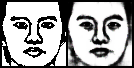

In [64]:
fixed_x = dataset[randint(2, 180)][0].unsqueeze(0)
compare_x = compare(fixed_x)

save_image(compare_x.data.cpu(), 'sample_image.png')
display(Image('sample_image.png', width=700, unconfined=True))